In [1]:
"""
Sasank Desaraju
12/25/2023

This notebook is to play with different code modules and see how they work
This is a repo about medical AI using Pytorch Lightning
"""

'\nSasank Desaraju\n12/25/2023\n\nThis notebook is to play with different code modules and see how they work\nThis is a repo about medical AI using Pytorch Lightning\n'

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
import lightning as L
import monai

In [3]:
# load and explore .npz file of image data
data = np.load('../data/chestmnist.npz')

In [4]:
# explore the np file of data. What fields does is contain?
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [5]:
train_images = data['train_images']
train_labels = data['train_labels']

In [14]:

class ChestMNISTDataModule(L.LightningDataModule):
    def __init__(self, data_dir: str = '../data', batch_size: int = 32, num_workers: int = 0, foo: int = 4):
        super().__init__()
        self.foo = foo
        print(self.foo)
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = monai.transforms.Compose(
            [
                #monai.transforms.LoadNiftid(keys=["image", "label"]),
                #monai.transforms.AddChanneld(keys=["image", "label"]),
                #monai.transforms.ScaleIntensityd(keys=["image"]),
                #monai.transforms.ToTensord(keys=["image", "label"]),
            ]
        )
    
    def prepare_data(self):
        # download, split, etc...
        # monai.data.Dataset.from_json(
        #     os.path.join(self.data_dir, "dataset.json"), 
        #     root_dir=self.data_dir, 
        #     transform=self.transform,
        # )
        return
    
    def setup(self, stage=None):
        # make assignments here (val/train/test split)
        # called on every process in DDP
        # stage defines if we are at fit or test step
        if stage == 'fit' or stage is None:
            data = np.load(os.path.join(self.data_dir, 'chestmnist.npz'))
            self.train_images = torch.from_numpy(data['train_images']).float()
            self.train_labels = torch.from_numpy(data['train_labels']).long()
            self.val_images = torch.from_numpy(data['val_images']).float()
            self.val_labels = torch.from_numpy(data['val_labels']).long()
        if stage == 'test' or stage is None:
            data = np.load(os.path.join(self.data_dir, 'chestmnist.npz'))
            self.test_images = torch.from_numpy(data['test_images']).float()
            self.test_labels = torch.from_numpy(data['test_labels']).long()

        """
        # Assign train/val datasets for use in dataloaders
        chestmnist = monai.data.Dataset.from_json(
            os.path.join(self.data_dir, "dataset.json"), 
            root_dir=self.data_dir, 
            transform=self.transform,
        )
        self.chestmnist_train, self.chestmnist_val, self.chestmnist_test = chestmnist.split(
            [0.8, 0.1, 0.1], 
            shuffle=True, 
            seed=42,
        )
        """
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.chestmnist_train, 
            batch_size=self.batch_size, 
            shuffle=True, 
            num_workers=self.num_workers,
        )
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.chestmnist_val, 
            batch_size=self.batch_size, 
            shuffle=False, 
            num_workers=self.num_workers,
        )
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.chestmnist_test, 
            batch_size=self.batch_size, 
            shuffle=False, 
            num_workers=self.num_workers,
        )


In [17]:

class ChestMNISTLitModel(L.LightningModule):
    def __init__(self, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.lr = lr
        self.loss = monai.losses.DiceLoss(sigmoid=True)
        self.accuracy = monai.metrics.DiceMetric(include_background=False, reduction="mean")
        
        # UNet model
        self.model = monai.networks.nets.UNet(
            spatial_dims=2,
            in_channels=1,
            out_channels=1,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
        )
        
    def forward(self, x):
        # called with self(x)
        return self.model(x)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self(x)
        loss = self.loss(logits, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self(x)
        loss = self.loss(logits, y)
        self.log('val_loss', loss)
        self.accuracy(y_pred=logits, y=y)
        self.log('val_dice', self.accuracy, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self(x)
        loss = self.loss(logits, y)
        self.log('test_loss', loss)
        self.accuracy(y_pred=logits, y=y)
        self.log('test_dice', self.accuracy, on_step=False, on_epoch=True, prog_bar=True)
        return loss

In [18]:
datamodule = ChestMNISTDataModule()
model = ChestMNISTLitModel()

4


In [ ]:
# Find number of unique labels in training set
n_classes = np.unique(train_labels)
n_classes
train_labels[0]
#train_labels[0].shape

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

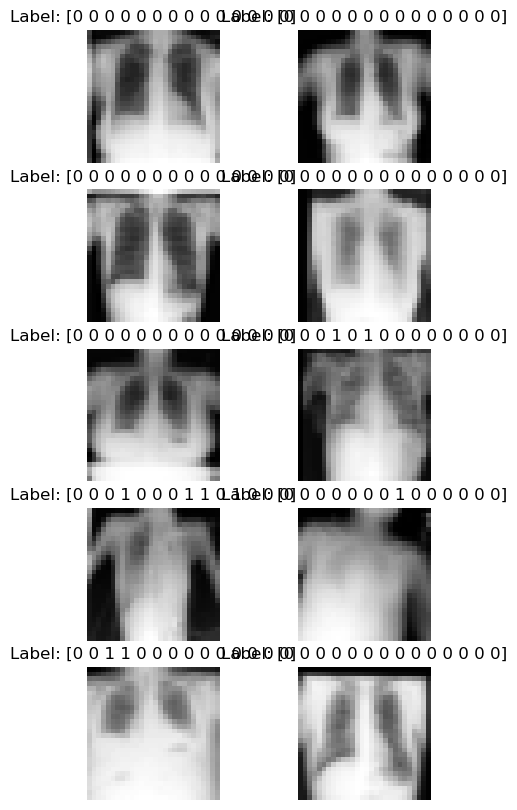

In [ ]:
# print a few images from the training set
# print them in a vertical grid
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(5, 10))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(train_images[i], cmap='gray')
    ax.set(title=f"Label: {train_labels[i]}")
    ax.axis('off')

In [ ]:
# Make a Pytorch Lightning Module for ChestMNIST using a CNN
class ChestMNISTLitModel(pl.LightningModule):
    def __init__(self, channels=[32, 64, 128, 256], kernel_size=3, pool_size=2, lr=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.channels = channels
        self.kernel_size = kernel_size
        self.pool_size = pool_size
        self.lr = lr
        self.loss = nn.CrossEntropyLoss()
        self.accuracy = pl.metrics.Accuracy()
        
        # convolutional layers
        self.convs = nn.Sequential(
            nn.Conv2d(1, channels[0], kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(pool_size),
            nn.Conv2d(channels[0], channels[1], kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(pool_size),
            nn.Conv2d(channels[1], channels[2], kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(pool_size),
            nn.Conv2d(channels[2], channels[3], kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(pool_size),
        )
        
        # dense layers
        self.linear_layers = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 14),
        )
        
    def forward(self, x):
        # called with self(x)
        x = self.convs(x)
        x = torch.flatten(x, 1)
        x = self.linear_layers(x)
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        logits = self(x)
        loss = self.loss(logits, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.accuracy(preds, y), prog_bar=True)
        return loss
    
    def test_step(self, test_batch, batch_idx):
        x, y = test_batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.accuracy(preds, y), prog_bar=True)
        return loss